distribution of main data

# some variables

In [ ]:
label1_th = 0.5

# -------- dataset
# software_name = "camel"
# software_name = "cloudstack"
software_name = "geode"
# software_name = "HBase"

# -------- check or show main dist
# check_working = "check"
check_working = "main_dist"

# Google Colab

In [ ]:
if software_name == "camel":
    dataset_file_name = "dataset_camel - v.01"
    
elif software_name == "cloudstack":
    dataset_file_name = "cloudstack_bugs - v.01"
    
elif software_name == "geode":
    dataset_file_name = "geode_Bug - v.01"
    
else:
    dataset_file_name = "dataset_hbase - v.03"

In [ ]:
# project folder path
project_folder = "gdrive/MyDrive/Colab Notebooks/paper/"

# data folder path
data_folder = "00- My Data/two-phase method/"

In [ ]:
pre_path_data =   project_folder + data_folder + software_name + "/"

# Libs

In [ ]:
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Config

In [ ]:
mypaths = {
    "dataset": pre_path_data + dataset_file_name + ".csv"
}

preprocessing_params = {
    "dataset": {
        # time_stamp is the time that we change the class for a bug fixing.
        # id stands for identifier
        "columns_name":   ["bug_report_id", "class_id", "time_stamp", "label"],
        "columns_dtype" : {0: "int64", 1: "int64", 2: "int64", 3:"int32"}
    },
    
    # 0: no change / 1: increase bad smell / -1: decrease bad smell
    "class_labels": [0, 1, -1], 
    "num_classes": 3,
    "label1_th": label1_th,
}

# Read Files

In [ ]:
df_main = pd.read_csv(
    mypaths["dataset"], 
    names=preprocessing_params["dataset"]["columns_name"], 
    dtype=preprocessing_params["dataset"]["columns_dtype"], 
    header=None
)

# ------ shrink the dataframe
if check_working == "check":
    my_indices_keep = slice(0, 100)
    df_main = df_main.iloc[my_indices_keep]
    df_main

In [ ]:
print("Number of rows:        ", len(df_main))
temp_1 = df_main.groupby("bug_report_id")
temp_2 = df_main.groupby("class_id")
print("Number of bug reports: ", len(temp_1))
print("Number of classes:     ", len(temp_2))

Number of rows:         308280
Number of bug reports:  3610
Number of classes:      16913


# BugClassSpecify

In [ ]:
class BugClassSpecify():
    
    def __init__(self, df, l1_th):
        # df: DataFrame("bug_report_id", "label|prediction_th")
        
        self.gdf = df.groupby("bug_report_id")
        self.l1_th = l1_th
        
        # df_bug_pred
        columns_name = ["bug_report_id", "bug_class_2"]
        columns_dtype = ["int64", "int32"]
        temp = {}
        for cn, cd in zip(columns_name, columns_dtype):
                temp[cn] = pd.Series(dtype=cd)
        self.df_bug_pred = pd.DataFrame(temp)
        self.df_bug_pred["bug_report_id"] = self.gdf.groups.keys()
        self.df_bug_pred["bug_class_2"] = self.df_bug_pred["bug_class_2"].astype("Int32")
    
    
    # =============================================
    #                   bug class
    # =============================================
    
    def bug_class(self):
        self.gdf.apply(lambda g: self.sub_bug_class_(g))
    
    
    def sub_bug_class_(self, g):
        # --------- bc_2: {1, 0}
        bc = None
        label_column = g.iloc[:, -1].to_list()
        label_column_num_ones = label_column.count(1)
        
        temp3 = label_column_num_ones / len(label_column)
        bc = 1 if temp3 >= self.l1_th else 0
        self.df_bug_pred.loc[(self.df_bug_pred["bug_report_id"] == g.name), "bug_class_2"] = bc
    
    
    def free_memory(self):
        self.gdf = None

## obj

In [ ]:
df_main_bug_preds_obj = BugClassSpecify(df_main.copy(), preprocessing_params["label1_th"])
df_main_bug_preds_obj.bug_class()
df_main_bug_preds_obj.free_memory()
df_main_bug_preds = df_main_bug_preds_obj.df_bug_pred
df_main_bug_preds

,bug_report_id,bug_class_2
0,27757,0
1,27758,0
2,27759,0
3,27760,0
4,27761,0
...,...,...
3605,39604,1
3606,39606,0
3607,39620,0
3608,39622,0


# NumTimeDatasetPlot

In [ ]:
class NumTimeDatasetPlot():
    
    def __init__(self, df_main, df_main_bug_preds):
        self.my_y_label = []
        self.my_x_nots = []
        self.df_main_bug_preds = df_main_bug_preds.copy()
    
    
    # brids: bug report ids
    # cids: class ids
    def select_brids_replace_cids(self):
        tempdf = df_main.groupby("bug_report_id")
        tempdf.apply(lambda g: self.replacement_false_(g))
    
    
    def replacement_false_(self, g):
        len_time_stamps = len(g)
        self.my_x_nots.append(len_time_stamps)
        # print(g.name)
        mytemp = self.df_main_bug_preds[self.df_main_bug_preds["bug_report_id"] == g.name]
        self.my_y_label.append(mytemp["bug_class_2"].item())
    
    
    def plotscatter(self):
        # figsize=(a, b) : a_width, b_height
        print(len(self.my_x_nots))
        print(len(self.my_y_label))
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
        axes.scatter(self.my_x_nots, self.my_y_label)
        
#         my_ts_max = max(self.my_x_nots)
#         axes.set_xlim([0, 200])

#         axes.set_ylim([-1, 2])
#         ax.get_yaxis().set_ticks(list(range(0, 101, 10)))
        
        
#         width = 0.2
#         my_x = [-0.3, -0.1, 0.1, 0.3]
        
#         temp1 = str(len(self.df_bug_pred))
#         temp2 = len(temp1) - 1
#         temp3 = "1" + "0" * temp2
#         temp4 = temp1[0] + "0" * temp2
#         temp5 = int(temp3) + int(temp4)
        
#         ml = list( range(0, temp5, int(temp3)) )
#         ml.append(len(self.df_bug_pred))
        
#         for i, key in enumerate(self.my_bug_classes):
#             ax1 = axes[0]
#             ax2 = axes[1]
#             for j, cl in enumerate(self.bug_class_per[key]):
#                 ax1.bar(my_x[j], self.bug_class_num[key][cl], width=width, label=cl, color=self.colours[j])
#                 ax2.bar(my_x[j], self.bug_class_per[key][cl], width=width, label=cl, color=self.colours[j])
            
#             tempXlabel = "{}".format(key)
#             ax1.set_xlabel(tempXlabel)
#             ax2.set_xlabel(tempXlabel)
            
#             ax1.set_ylabel("Number of Bug Reports")
#             ax2.set_ylabel("Percentages (%)")
            
#             tempXlim = [-0.5, 0.5]
#             ax1.set_xlim(tempXlim)
#             ax2.set_xlim(tempXlim)
            
            
#             ax1.set_ylim([0, temp5])
#             ax2.set_ylim([0, 110])
            
            
#             ax1.get_xaxis().set_ticks([])
#             ax2.get_xaxis().set_ticks([])
            
            
#             ax1.get_yaxis().set_ticks(ml)
#             ax2.get_yaxis().set_ticks(list(range(0, 101, 10)))
            
#             ax1.legend()
#             ax2.legend()
            
#             ax1.grid(axis="y")
#             ax2.grid(axis="y")
        
        #fig.suptitle("bla: {}, th: {}".format(bla, th), fontsize=16)
        fig.tight_layout(pad=3.0)
        
    def plotdist(self):
        my_xx=np.unique(self.my_x_nots)
        my_yy = []
        # print(type(my_xx))
        print(len(my_xx))
        for unel in my_xx:
            my_yy.append(self.my_x_nots.count(unel))
        #print(my_xx)
        print(len(my_xx))
        #print(my_yy)
        print(len(my_yy))
        
#         # figsize=(a, b) : a_width, b_height
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 20))
        axes[0].scatter(my_xx, my_yy)
        
#         my_ts_max = max(self.my_x_nots)
        #axes[0].set_xlim([0, 20])
    
    
        ttt = np.cumsum(my_yy)
        axes[1].plot(my_xx, ttt)
#         axes[1].set_xlim([0, 200])
#         axes[1].set_ylim([1, 40])

## obj

In [ ]:
ntdppp = NumTimeDatasetPlot(df_main, df_main_bug_preds.copy())
ntdppp.select_brids_replace_cids()

In [ ]:
print(len(ntdppp.my_y_label))
print(len(ntdppp.my_x_nots))

3610
3610


381
381
381


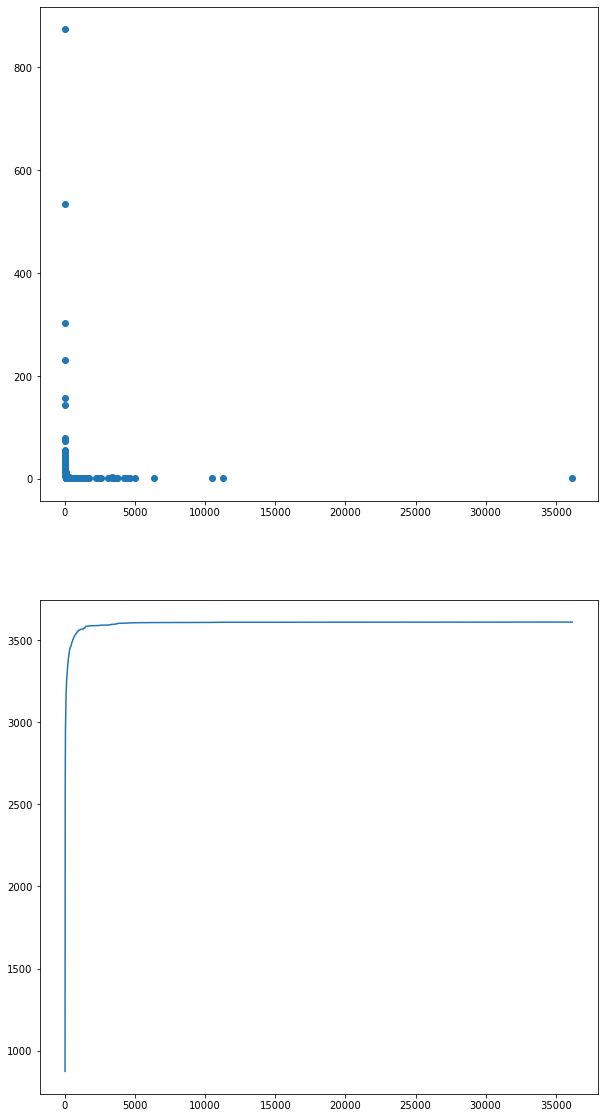

In [ ]:
ntdppp.plotdist()

3610
3610


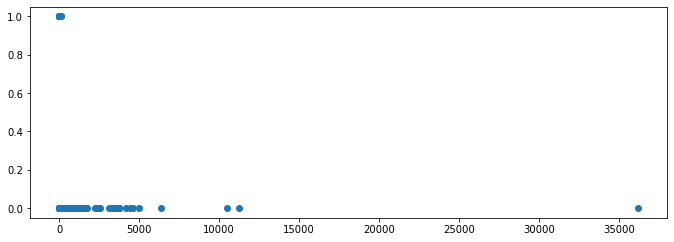

In [ ]:
ntdppp.plotscatter()

# ClassDistribution

In [ ]:
class ClassDistribution:
    
    def __init__(self, df_bug_pred):
        self.df_bug_pred = df_bug_pred
        self.my_bug_classes = ["bug_class_2"]
        self.bug_class_num = {}
        self.bug_class_per = {}
        self.bug_class_ratio = {}
        
        for i, bug_class in enumerate(self.my_bug_classes):
            self.bug_class_ratio[bug_class] = {}
            if i == 0: # bug_label_2
                self.bug_class_num[bug_class] =   {"0": 0, "1":  0}
                self.bug_class_per[bug_class] =   {"0": 0, "1":  0}
        
        # plot values
        self.colours = ["red", "blue", "green", "cyan"]
    
    
    # --------------------------- calc_bug_label_num
    
    def calc_bug_label_num_per(self):
        self.df_bug_pred.groupby("bug_class_2").apply(lambda g: self.sub_bln_(g, "bug_class_2"))
    
    
    def sub_bln_(self, g, gby):
        self.bug_class_num[gby][str(g.name)] = len(g)
        self.bug_class_per[gby][str(g.name)] = (len(g) / len(self.df_bug_pred)) * 100
    
    
    # --------------------------- calc_ratios
    
    def calc_bug_label_ratios(self):
        
        for bug_class in self.my_bug_classes:
            temp = self.bug_class_num[bug_class]
            mydata_sorted = [(key, value) for key, value in sorted(temp.items(), 
                                                                   key=lambda item: item[1], reverse=True)]
        
            num_classes = len(temp)
            for i in range(num_classes - 1):
                for j in range(i + 1, num_classes):
                    tempKey1 = mydata_sorted[i][0]
                    tempKey2 = mydata_sorted[j][0]
                    mykey = tempKey1 + "/" + tempKey2

                    tempValue1 = mydata_sorted[i][1]
                    tempValue2 = mydata_sorted[j][1]
                    if tempValue2 != 0:
                        self.bug_class_ratio[bug_class][mykey] = tempValue1 / tempValue2
    
    
    # --------------------------- bar plot
    
    def plot_percent_num(self, bla, th):
        # figsize=(a, b) : a_width, b_height
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
        width = 0.2
        my_x = [-0.3, -0.1, 0.1, 0.3]
        
        temp1 = str(len(self.df_bug_pred))
        temp2 = len(temp1) - 1
        temp3 = "1" + "0" * temp2
        temp4 = temp1[0] + "0" * temp2
        temp5 = int(temp3) + int(temp4)
        
        ml = list( range(0, temp5, int(temp3)) )
        ml.append(len(self.df_bug_pred))
        
        for i, key in enumerate(self.my_bug_classes):
            ax1 = axes[0]
            ax2 = axes[1]
            for j, cl in enumerate(self.bug_class_per[key]):
                ax1.bar(my_x[j], self.bug_class_num[key][cl], width=width, label=cl, color=self.colours[j])
                ax2.bar(my_x[j], self.bug_class_per[key][cl], width=width, label=cl, color=self.colours[j])
            
            tempXlabel = "{}".format(key)
            ax1.set_xlabel(tempXlabel)
            ax2.set_xlabel(tempXlabel)
            
            ax1.set_ylabel("Number of Bug Reports")
            ax2.set_ylabel("Percentages (%)")
            
            tempXlim = [-0.5, 0.5]
            ax1.set_xlim(tempXlim)
            ax2.set_xlim(tempXlim)
            
            
            ax1.set_ylim([0, temp5])
            ax2.set_ylim([0, 110])
            
            
            ax1.get_xaxis().set_ticks([])
            ax2.get_xaxis().set_ticks([])
            
            
            ax1.get_yaxis().set_ticks(ml)
            ax2.get_yaxis().set_ticks(list(range(0, 101, 10)))
            
            ax1.legend()
            ax2.legend()
            
            ax1.grid(axis="y")
            ax2.grid(axis="y")
        
        fig.suptitle("bla: {}, th: {}".format(bla, th), fontsize=16)
        fig.tight_layout(pad=3.0)
    
    
    def free_memory(self):
        self.df_bug_pred = None

## obj

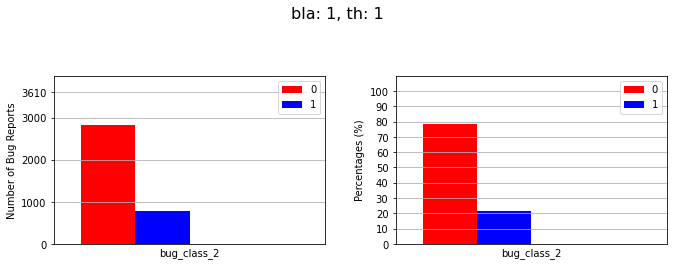

In [ ]:
df_main_bug_plot = ClassDistribution(df_main_bug_preds)
df_main_bug_plot.calc_bug_label_num_per()
df_main_bug_plot.calc_bug_label_ratios()
df_main_bug_plot.plot_percent_num(1, 1)
df_main_bug_plot.free_memory()

In [ ]:
df_main_bug_plot.bug_class_num

{'bug_class_2': {'0': 2839, '1': 771}}

In [ ]:
df_main_bug_plot.bug_class_per

{'bug_class_2': {'0': 78.6426592797784, '1': 21.357340720221607}}

In [ ]:
df_main_bug_plot.bug_class_ratio

{'bug_class_2': {'0/1': 3.682230869001297}}

# NumTimeDataset

In [ ]:
class NumTimeDataset():
    
    def __init__(self, df_main):
        self.max_bug_timestamp = 0
        self.max_bug_timestamp_bid = None
        self.num_timestamp = 5
        self.bug_timestamp_num = {}
        self.bug_timestamp_perc = {}
        
        for i in range(1, self.num_timestamp + 1):
            tempstr = "bug_timestamp_" + str(i)
            self.bug_timestamp_num[tempstr] = 0
            self.bug_timestamp_perc[tempstr] = 0
        
        temp1 = "bug_timestamp_<=" + str(self.num_timestamp)
        temp2 = "bug_timestamp_>" + str(self.num_timestamp)
        
        
        self.bug_timestamp_num[temp1] = 0
        self.bug_timestamp_num[temp2] = 0
        
        self.bug_timestamp_perc[temp1] = 0
        self.bug_timestamp_perc[temp2] = 0
    
    
    # brids: bug report ids
    # cids: class ids
    def select_brids_replace_cids(self):
        tempdf = df_main.groupby("bug_report_id")
        tempdf.apply(lambda g: self.replacement_false_(g))
        for k, percentage in self.bug_timestamp_perc.items():
            self.bug_timestamp_perc[k] = round((self.bug_timestamp_num[k] / len(tempdf)) * 100, 2)
    
    
    def replacement_false_(self, g):
        len_time_stamps = len(g)
        
        if len_time_stamps > self.num_timestamp:
            temp3 = "bug_timestamp_>" + str(self.num_timestamp)
            self.bug_timestamp_num[temp3] += 1
        
        else:
            temp4 = "bug_timestamp_<=" + str(self.num_timestamp)
            self.bug_timestamp_num[temp4] += 1
            
            for j in range(1, self.num_timestamp + 1):
                if len_time_stamps == j:
                    temp5 = "bug_timestamp_" + str(j)
                    self.bug_timestamp_num[temp5] += 1
                    break
        
        if len_time_stamps > self.max_bug_timestamp:
            self.max_bug_timestamp = len_time_stamps
            self.max_bug_timestamp_bid = g.name

## obj

In [ ]:
md = NumTimeDataset(df_main.copy())

md.select_brids_replace_cids()

In [ ]:
# print(str(md.bug_timestamp_num))
for k, v in md.bug_timestamp_num.items():
    print(k, v)

bug_timestamp_1 874
bug_timestamp_2 535
bug_timestamp_3 303
bug_timestamp_4 230
bug_timestamp_5 158
bug_timestamp_<=5 2100
bug_timestamp_>5 1510


In [ ]:
md.bug_timestamp_perc

{'bug_timestamp_1': 24.21,
 'bug_timestamp_2': 14.82,
 'bug_timestamp_3': 8.39,
 'bug_timestamp_4': 6.37,
 'bug_timestamp_5': 4.38,
 'bug_timestamp_<=5': 58.17,
 'bug_timestamp_>5': 41.83}

In [ ]:
print("num cid: ", md.max_bug_timestamp)
print("bug id:  ", md.max_bug_timestamp_bid)

num cid:  36184
bug id:   34372


# NumLabel1Dataset

In [ ]:
class NumLabel1Dataset():
    
    def __init__(self, df_main):
        self.num_label1 = 100
        self.num_ts = 5
        
        self.max_bug_label1 = 0
        self.max_bug_num_ts = 0
        self.max_bug_label1_bid = None
        
        self.bug_label1_num = {}
        self.bug_label1_perc = {}
        self.bug_label1_num_class = {}
        
        
        tempra = ["<=" + str(self.num_label1), ">" + str(self.num_label1)]
        tempra.extend(list(range(0, self.num_label1 + 1)))
        #tempra.extend(["<=", ">"])
        print(tempra)
        
        tempts = list(range(1, self.num_ts + 1))
        tempts.extend(["<="  + str(self.num_ts), ">" + str(self.num_ts)])
        print(tempts)
        
        
        for i in tempra:
            tempstr = "bug_label1_" + str(i)
            self.bug_label1_num[tempstr] = 0
            self.bug_label1_perc[tempstr] = 0
            
            self.bug_label1_num_class[tempstr] = {}
            for j in tempts:
                tempnumts = "num_ts_" + str(j)
                self.bug_label1_num_class[tempstr][tempnumts] = 0
        
    
    
    # brids: bug report ids
    # cids: class ids
    def select_brids_replace_cids(self):
        tempdf = df_main.groupby("bug_report_id")
        tempdf.apply(lambda g: self.replacement_false_(g))
        for k, percentage in self.bug_label1_perc.items():
            self.bug_label1_perc[k] = round((self.bug_label1_num[k] / len(tempdf)) * 100, 2)
    
    
    def replacement_false_(self, g):
        labels = g["label"].to_list()
        num1_label = labels.count(1)
        tempKey = None
        tempKey_small = None
        
        tempKey2 = None
        
        if num1_label > self.num_label1:
            tempKey = "bug_label1_>" + str(self.num_label1)
        else:
            tempKey_small = "bug_label1_<=" + str(self.num_label1)
            self.bug_label1_num[tempKey_small] += 1
            
            tempKey = "bug_label1_" + str(num1_label)
        
        self.bug_label1_num[tempKey] += 1
        
        # ------ num_ts
        if len(labels) > self.num_ts:
            tempKey2 = "num_ts_>" + str(self.num_ts)
        else:
            tempKey2_small = "num_ts_<=" + str(self.num_ts)
            self.bug_label1_num_class[tempKey][tempKey2_small] += 1
            
            tempKey2 = "num_ts_" + str(len(labels))
        
        self.bug_label1_num_class[tempKey][tempKey2] += 1
        if tempKey_small:
            self.bug_label1_num_class[tempKey_small][tempKey2] += 1
        
        if num1_label > self.max_bug_label1:
            self.max_bug_label1 = num1_label
            self.max_bug_num_ts = len(labels)
            self.max_bug_label1_bid = g.name

## obj

In [ ]:
a = [1, 1, -1, 0, 0, 0]
a.count(-1)

1

In [ ]:
md2 = NumLabel1Dataset(df_main.copy())

# md2.bug_label1_num_class
# md2.bug_label1_num
md2.select_brids_replace_cids()

['<=100', '>100', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
[1, 2, 3, 4, 5, '<=5', '>5']


In [ ]:
# print(str(md.bug_timestamp_num))
for k, v in md2.bug_label1_num.items():
    print(k, v)

bug_label1_<=100 3555
bug_label1_>100 55
bug_label1_0 1399
bug_label1_1 826
bug_label1_2 392
bug_label1_3 181
bug_label1_4 117
bug_label1_5 73
bug_label1_6 58
bug_label1_7 36
bug_label1_8 39
bug_label1_9 43
bug_label1_10 31
bug_label1_11 24
bug_label1_12 17
bug_label1_13 16
bug_label1_14 9
bug_label1_15 16
bug_label1_16 11
bug_label1_17 14
bug_label1_18 11
bug_label1_19 5
bug_label1_20 7
bug_label1_21 9
bug_label1_22 5
bug_label1_23 5
bug_label1_24 3
bug_label1_25 3
bug_label1_26 5
bug_label1_27 4
bug_label1_28 5
bug_label1_29 2
bug_label1_30 3
bug_label1_31 4
bug_label1_32 4
bug_label1_33 9
bug_label1_34 2
bug_label1_35 6
bug_label1_36 5
bug_label1_37 4
bug_label1_38 9
bug_label1_39 6
bug_label1_40 6
bug_label1_41 5
bug_label1_42 11
bug_label1_43 4
bug_label1_44 4
bug_label1_45 3
bug_label1_46 3
bug_label1_47 3
bug_label1_48 4
bug_label1_49 3
bug_label1_50 4
bug_label1_51 4
bug_label1_52 3
bug_label1_53 2
bug_label1_54 4
bug_label1_55 2
bug_label1_56 4
bug_label1_57 2
bug_label1_58 1


In [ ]:
md2.bug_label1_perc

{'bug_label1_<=100': 98.48,
 'bug_label1_>100': 1.52,
 'bug_label1_0': 38.75,
 'bug_label1_1': 22.88,
 'bug_label1_2': 10.86,
 'bug_label1_3': 5.01,
 'bug_label1_4': 3.24,
 'bug_label1_5': 2.02,
 'bug_label1_6': 1.61,
 'bug_label1_7': 1.0,
 'bug_label1_8': 1.08,
 'bug_label1_9': 1.19,
 'bug_label1_10': 0.86,
 'bug_label1_11': 0.66,
 'bug_label1_12': 0.47,
 'bug_label1_13': 0.44,
 'bug_label1_14': 0.25,
 'bug_label1_15': 0.44,
 'bug_label1_16': 0.3,
 'bug_label1_17': 0.39,
 'bug_label1_18': 0.3,
 'bug_label1_19': 0.14,
 'bug_label1_20': 0.19,
 'bug_label1_21': 0.25,
 'bug_label1_22': 0.14,
 'bug_label1_23': 0.14,
 'bug_label1_24': 0.08,
 'bug_label1_25': 0.08,
 'bug_label1_26': 0.14,
 'bug_label1_27': 0.11,
 'bug_label1_28': 0.14,
 'bug_label1_29': 0.06,
 'bug_label1_30': 0.08,
 'bug_label1_31': 0.11,
 'bug_label1_32': 0.11,
 'bug_label1_33': 0.25,
 'bug_label1_34': 0.06,
 'bug_label1_35': 0.17,
 'bug_label1_36': 0.14,
 'bug_label1_37': 0.11,
 'bug_label1_38': 0.25,
 'bug_label1_39': 0.

In [ ]:
print("num cid: ", md2.max_bug_label1)
print("num ts:  ", md2.max_bug_num_ts)
print("bug id:  ", md2.max_bug_label1_bid)

num cid:  2486
num ts:   11232
bug id:   34589


In [ ]:
md2.bug_label1_num_class

{'bug_label1_<=100': {'num_ts_1': 874,
  'num_ts_2': 535,
  'num_ts_3': 303,
  'num_ts_4': 230,
  'num_ts_5': 158,
  'num_ts_<=5': 0,
  'num_ts_>5': 1455},
 'bug_label1_>100': {'num_ts_1': 0,
  'num_ts_2': 0,
  'num_ts_3': 0,
  'num_ts_4': 0,
  'num_ts_5': 0,
  'num_ts_<=5': 0,
  'num_ts_>5': 55},
 'bug_label1_0': {'num_ts_1': 671,
  'num_ts_2': 249,
  'num_ts_3': 118,
  'num_ts_4': 83,
  'num_ts_5': 54,
  'num_ts_<=5': 1175,
  'num_ts_>5': 224},
 'bug_label1_1': {'num_ts_1': 203,
  'num_ts_2': 211,
  'num_ts_3': 116,
  'num_ts_4': 69,
  'num_ts_5': 43,
  'num_ts_<=5': 642,
  'num_ts_>5': 184},
 'bug_label1_2': {'num_ts_1': 0,
  'num_ts_2': 75,
  'num_ts_3': 53,
  'num_ts_4': 54,
  'num_ts_5': 38,
  'num_ts_<=5': 220,
  'num_ts_>5': 172},
 'bug_label1_3': {'num_ts_1': 0,
  'num_ts_2': 0,
  'num_ts_3': 16,
  'num_ts_4': 21,
  'num_ts_5': 14,
  'num_ts_<=5': 51,
  'num_ts_>5': 130},
 'bug_label1_4': {'num_ts_1': 0,
  'num_ts_2': 0,
  'num_ts_3': 0,
  'num_ts_4': 3,
  'num_ts_5': 7,
  'nu

# test

In [ ]:
math.ceil(0.7)

1